# Running inference for Varational AutoEncoder (VAE)

This notebook contains the code to run the inference of the model at testing time. The testing data, in this case initial conditions and PDE parameters, should have respectively dimensions [B,1,C,x1_dim,x2_dim, ...] and [B,N_m], where B is the batch size, C is the number channels of the solution fields, x1_dim,x2_dim and so on are the spatial resolutions of first and second dimensions and so on, and N_m is the number of parameters

# Import necessary libraries

In [57]:
import numpy as np
import torch as tc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import pandas as pd
import re
import sys
import yaml
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import time
import h5py
tc.set_default_dtype(tc.float32)

# Functions

In [58]:
def load_config(config_path: str):
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

def normalize_field_known_values(F, ma, mi):
    for count in range(len(ma)):
        F[:,:,count,...] = (F[:,:,count,...]-mi[count])/(ma[count]-mi[count])
    return F

def normalize_field_known_values_param(F, ma,mi):
    return (F-mi)/(ma-mi)

def inverse_normalization_field(F,ma,mi, spatial_dimensions): #here one less dimension because the dimension 1 is squeezed in that part of the code
    if spatial_dimensions == 1:
        for count in range(len(ma)):
            F[...,count,:] = F[...,count,:]*(ma[count]-mi[count]) + mi[count]
        return F
    elif spatial_dimensions == 2:
        for count in range(len(ma)):
            F[...,count,:,:] = F[...,count,:,:]*(ma[count]-mi[count]) + mi[count]
        return F

def molenkeamp(X,Y, param, t):
    h = np.sqrt((X-param[3]+0.5*np.cos(2*np.pi*t))**2+(Y-param[4]+0.5*np.sin(2*np.pi*t))**2)
    
    return param[0]*0.01**(param[1]*h**2)*np.exp(-param[2]*t)

def get_diff_time_from_dataset(path, skipping_index):
    file = h5py.File(path+'/2D_rdb_NA_NA.h5', 'r')
    keys = file.keys()
    data = file['0212']['grid']
    T = []
    for t in data['t'][::skipping_index]:
        T.append(t)

    out = [] 
    for i in list(keys)[900:]:
        data = file[i]['data'][::skipping_index]
        out.append(np.reshape(data,(np.shape(data)[0],128,128)))
    return np.array(out), T
    
class CustomStarDataset(Dataset):
    # This loads the data and converts it, make data rdy
    def __init__(self,file_path_ic,file_path_parameter ):
        self.ic = tc.tensor(np.load(file_path_ic), dtype = tc.float32)
        self.params = tc.tensor(np.load(file_path_parameter), dtype = tc.float32)
        
    
    # This returns the total amount of samples in your Dataset
    def __len__(self):
        return len(self.ic)
    
    # This returns given an index the i-th sample and label
    def __getitem__(self, idx):
        return self.ic[idx],self.params[idx]
def advection(x,mu,t):
    length = len(x)
    advected = np.zeros(length)
    for i in range(length):
        if i/length < mu*t:
            advected[i] = x[0]
        else:
            advected[i] = x[int(i-mu*t*length)]
    return advected

def processor_First_Order(f, e1,dt, mu, k, RK, ma_mi, device, time_dependence_in_f):
    """this function implements the Runge-Kutta algorithms. First_Order refers to the fact that the ODE is a first order ODE, although higher orders would still be solved by this algorithms
    simply introducing new functions.

    Args:
        f (src.architecture.F_Latent): function f of the ODE of the latent dynamics
        e1 (torch.tensor()): tensor of dimension [B, dim_latent], where B is the batch size and dim_latent the dimension of the latent space
        dt (torch.Tensor): a tensor containing the dts used to advance each snapshot in time. It has dimensions [B, T-1], where B is the batch size and T is the length of the time series. it assumes each batch evolves accordingly to the same dts 
        mu (tc.tensor()): tensor of dimension [B, num_params] where B is the batch size and num_params the number of parameters of the system
        k (int): stage of Runge-Kutta algorithm
        RK (dict): dictionary with Butcher tablue for Runge-Kutta algorithms
        ma_mi (list): list of lists of maximum and minima of fields and parameters
        device (torch.device): device where the training and validation are done
        time_dependence_in_f (bool):  if true, the function f depends on time as well.

    Returns:
        torch.tensor(): tensor of dimension [B, dim_latent] which contains the latent vectors advanced in time from e1 of dt
    """    
    # k=1 is Euler
    ma_mi[2] = ma_mi[2].to(device)
    ma_mi[3] = ma_mi[3].to(device)
    mu = normalize_field_known_values_param(mu, ma_mi[2], ma_mi[3])
    b = tc.zeros((k, e1.size(0), e1.size(1)) , device= device)
    b[0, :,:] = f(e1, mu )
    final_sum = f(e1, mu)*RK[str(k)][-1][1]

    for i in range(k-1):
        mu_in_time = mu.clone() #avoid in place operation which messes with backprop.
        if time_dependence_in_f:
            mu_in_time[:,-1] = mu_in_time[:,-1] +  RK[str(k)][i+1][0] * dt.squeeze(-1) 
        s = tc.zeros_like(e1, device = device)

        for j in range(i+1):
            s +=  b[j] * RK[str(k)][i+1][j+1]

        b_new = f(e1 + dt * s, mu_in_time).unsqueeze(0).to(device)
        b[i+1,:,:] = b_new

        final_sum += b_new.squeeze(0) * RK[str(k)][-1][i+2]
    e2 = e1 + final_sum * dt
    return e2

def predict_spatio_temporal_norm_param_in_latent_space(conv_encoder, f, conv_decoder, initial_cond, T, param, normalization, k, device, dim_input, ma_field, mi_field, ma_p,mi_p, field_dimension, time_dependence_in_f):
    
    predictions = initial_cond.clone().to(device)
    initial_cond = normalize_field_known_values(initial_cond,ma_field,mi_field).to(device)

    x_grid = np.shape(initial_cond)[-1]
    y_grid = np.shape(initial_cond)[-2]
    batch_num = initial_cond.size()[0]

    if dim_input == 1:
        latent = conv_encoder(initial_cond.reshape(batch_num , field_dimension[0], x_grid)).unsqueeze(1)
    else:
        latent = conv_encoder(initial_cond.reshape(batch_num , field_dimension[0], y_grid, x_grid)).unsqueeze(1)

    for count, i in enumerate(T[1:]):
        dt = tc.tensor(i-T[count]).expand(batch_num, 1).to(device)
        latent_new = processor_First_Order(f, latent[:,-1,:], dt, param, k, RK, [ma_field,mi_field, ma_p, mi_p],device, time_dependence_in_f)
        latent = tc.cat((latent, latent_new.unsqueeze(1)),dim = 1)

        field_prediction = conv_decoder(latent_new).unsqueeze(1)
        predictions = tc.cat((predictions, inverse_normalization_field(field_prediction,ma_field,mi_field, field_dimension[1])),dim = 1)
    return predictions.squeeze(0).detach().cpu().numpy(), latent.squeeze(0).detach().cpu().numpy()

def predict_spatio_temporal_norm_param_in_latent_space_for_time_inference(conv_encoder, f, conv_decoder, initial_cond, T, param, normalization, k, device, dim_input, ma_field, mi_field, ma_p,mi_p, field_dimension, time_dependence_in_f):
    
    initial_cond = normalize_field_known_values(initial_cond,ma_field,mi_field)

    x_grid = np.shape(initial_cond)[-1]
    y_grid = np.shape(initial_cond)[-2]
    batch_num = initial_cond.size()[0]

    if dim_input == 1:
        latent = conv_encoder(initial_cond.reshape(batch_num , field_dimension[0], x_grid)).unsqueeze(1)
    else:
        latent = conv_encoder(initial_cond.reshape(batch_num , field_dimension[0], y_grid, x_grid)).unsqueeze(1)

    for count, i in enumerate(T[1:]):
        dt = tc.tensor(i-T[count]).expand(batch_num, 1).to(device)
        latent_new = processor_First_Order(f, latent[:,-1,:], dt, param, k, RK, [ma_field,mi_field, ma_p, mi_p],device, time_dependence_in_f)
        latent = tc.cat((latent, latent_new.unsqueeze(1)),dim = 1)
    size_latent = latent.size()
    latent = tc.reshape(latent,(size_latent[0]*size_latent[1],size_latent[2] ))
    out = conv_decoder(latent)
    if dim_input == 1:
        out = tc.reshape(out,(batch_num, len(T),field_dimension[0],x_grid))
    else:
        out = tc.reshape(out,(batch_num, len(T),field_dimension[0], y_grid, x_grid))
    predictions = inverse_normalization_field(out ,ma_field,mi_field, field_dimension[1])
    return predictions


def build_dataset_finer_time( T, testing_parameters, ic):
    expected = []
    for count, init in enumerate(ic):
        out = []
        for t in T:
            result = advection(init, testing_parameters[count], t)
            out.append(result)
        expected.append(out)
        
    return expected

def build_dataset_finer_time_molenkamp(testing, T, testing_parameters):
    expected = []
    a = np.linspace(-1,1,128)
    b = np.linspace(1,-1,128)
    X, Y = np.meshgrid(a, b)
    with tc.no_grad():
        for ic, _ in testing:
            for count,_ in enumerate(ic.detach().cpu().numpy()):
                expected.append([molenkeamp(X,Y, testing_parameters[count] , j) for j in T])
    return expected



# Set path to saved NNs models, path to data for testing and necessary directories

In [59]:
path_models = '../../datasets/gaussian_shape/Models/VAE/try_3/'
data_generation_test = '../../../../../../scratch/aalelonghi/gaussian_shapes'

directory_images = path_models+'/Images/'
os.makedirs(directory_images, exist_ok=True)
sys.path.append(path_models + '/scripts')
from models.VAE.VAE_model import *

#set device
device = tc.device("cuda:2") if tc.cuda.is_available() else tc.device("cpu")
print(f'Selected device: {device}')

#read file with normalization of inputs
normalization = pd.read_csv(path_models+'/Normalization.csv')
string_field = normalization['Field'][0].split("), 'Min': tensor(")
ma_field = tc.tensor([float(x) for x in string_field[0][16:-2].split(",")], device=device)
mi_field = tc.tensor([float(x) for x in string_field[1][1:-3].split(",")], device = device)

print('maximum value field', ma_field)
print('minimum value field', mi_field)

global_information = load_config(path_models + '/scripts/configs/global_information.yaml')
model_information = load_config(path_models + '/scripts/configs/information_VAE.yaml')
print(model_information)
global_information['PATH'] = 'boh'

Selected device: cuda:2
maximum value field tensor([1.], device='cuda:2')
minimum value field tensor([0.], device='cuda:2')
{'kernel_encoder': [5, 5, 3, 3, 3, 3, 3], 'filters_encoder': [8, 16, 32, 32, 32, 32, 2], 'stride_encoder': [1, 2, 2, 2, 2, 1, 1], 'latent_dimension': 3, 'kernel_decoder': [3, 4, 4, 4, 4, 3, 3, 3], 'number_channels_input_cnns_deco': 2, 'filters_decoder': [32, 32, 32, 32, 32, 16, 1], 'stride_decoder': [1, 2, 2, 2, 2, 1, 1, 1], 'final_and_initial_activation': False, 'training_loss_coefficients': {'l_reconstruction': 1.0, 'kl_regularization': 1.0, 'total': 'None'}, 'validation_loss_coefficients': {'l_reconstruction': 1.0, 'l_reconstruction_unnormed': 1.0, 'kl_regularization': 1.0, 'total': 'None'}, 'dynamically_increasing_losses': {'kl_regularization_strength': 0.01}}


# Load weights of the saved models and define specific settings of the problem

In [60]:
model = Variational_AutoEncoder(global_information, model_information)
conv_encoder = model.encoder
conv_decoder = model.decoder

checkpoint = tc.load(path_models+'/checkpoint/check.pt', map_location=device, weights_only=True)
conv_encoder.load_state_dict(checkpoint['enco'])
conv_decoder.load_state_dict(checkpoint['dec'])

total_params_enc = sum(p.numel() for p in conv_encoder.parameters() if p.requires_grad)
total_params_dec = sum(p.numel() for p in conv_decoder.parameters() if p.requires_grad)

memory_in_mb = (total_params_enc+total_params_dec * 4) / (1024 ** 2)
print(f"Model memory: {memory_in_mb:.2f} MB")

print(f"Total number of parameters enc: {total_params_enc}")
print(f"Total number of parameters dec : {total_params_dec}")
print(f"Total number of parameters: {total_params_enc+total_params_dec}")

conv_encoder.to(device)
conv_decoder.to(device)

conv_encoder.eval()
conv_decoder.eval()


Model memory: 0.31 MB
Total number of parameters enc: 36776
Total number of parameters dec : 71570
Total number of parameters: 108346


Convolutional_Variational_Decoder(
  (transposed_convolutionals): ModuleList(
    (0): ConvTranspose2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1-4): 4 x ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (relu): ReLU()
  (gelu): GELU(approximate='none')
  (tanh): Tanh()
  (elu): ELU(alpha=1.0)
  (activation): GELU(approximate='none')
  (log_variances_dfnn): Linear(in_features=6, out_features=1, bias=True)
  (dfnn): Linear(in_features=3, out_features=128, bias=True)
)

# Define testing objects

In [65]:
testing_time_serie = np.array(np.load(data_generation_test+"/test_field_x.npy"),dtype="float32") #should be of size [B,T,C,W,H]
testing_parameters = np.array(np.load(data_generation_test+"/test_field_parameters_x.npy"),dtype="float32")
#testing_T = np.array(np.load(data_generation_test+"/testing_T.npy"),dtype="float32")
#ic = np.array(np.load(data_generation_test+"/testing_initial_conditions.npy"),dtype="float32")
testing_T = np.array([0.0])#np.arange(0,1.05,0.05,dtype="float32")

#testing_time_serie_diff_time = np.load('../../../../../../../scratch/aalelonghi/benchmark/burgers_0.001/discretization_0.01/testing_output.npy')
#inference_T = np.float32(np.arange(0,2.01,0.01))

#if needed, adjust the dimension of testing_time_serie
testing_time_serie = testing_time_serie[:,:,None,:]
#testing_time_serie_diff_time = testing_time_serie_diff_time[:,:,None,:]

print('testing_time_serie',np.shape(testing_time_serie ))
#print('testing_parameters',np.shape(testing_parameters ))
#print('ic',np.shape(ic ))
#print('testing_T',np.shape(testing_T ))
#print('testing_time_serie_diff_time',np.shape(testing_time_serie_diff_time ))
#print('inference_T',np.shape(inference_T ))


testing_time_serie (100, 1, 1, 1, 128, 128)


# Define some needed details

In [66]:
latent_dim = model_information['latent_dimension'] #dimension of the latent space 
dim_field = global_information['dim_input'] # first dimension is the channels of the solution field, second is the number of spatial dimensions

# Prediction when Encoding and then Decoding the testing dataset using the **training** dt

In [67]:
testing_time_serie = np.squeeze(testing_time_serie, axis = 2)
tensor_time_serie = normalize_field_known_values(tc.tensor(testing_time_serie, device=device),ma_field,mi_field)
size = tensor_time_serie.size()
print('tensor_time_serie', tensor_time_serie.size())
if dim_field[1] == 1:
    tensor_time_serie = tc.reshape(tensor_time_serie, (size[0]*size[1],size[2],size[3]))
elif dim_field[1] == 2:
    tensor_time_serie = tc.reshape(tensor_time_serie, (size[0]*size[1],size[2],size[3],size[4]))
print(tensor_time_serie.size())

with tc.no_grad():
    mid_point_encoded_training, means, log_variances = conv_encoder(tensor_time_serie)
    print(mid_point_encoded_training.size())
    mid_point_decoded, log_variances_fields = conv_decoder(mid_point_encoded_training, means,log_variances)
mid_point_encoded_training = tc.reshape(mid_point_encoded_training, (size[0],size[1],latent_dim)).detach().cpu().numpy()
mid_point_decoded = inverse_normalization_field(mid_point_decoded,ma_field,mi_field, dim_field[1])
if dim_field[1] == 1: 
    mid_point_decoded_training = tc.reshape(mid_point_decoded, (size[0],size[1],size[2],size[3])).detach().cpu().numpy()
elif dim_field[1] == 2:
    mid_point_decoded_training = tc.reshape(mid_point_decoded, (size[0],size[1],size[2],size[3],size[4])).detach().cpu().numpy() 

log_variances_fields = tc.reshape(tc.exp(log_variances_fields)**0.5,(size[0],size[1],1)).detach().cpu().numpy()

print('mid_point_decoded_training', np.shape(mid_point_decoded_training))
print('log_variances_fields', np.shape(log_variances_fields))
means = tc.reshape(means, (size[0],size[1],size[2],latent_dim)).squeeze(2).detach().cpu().numpy()
sigmas = tc.reshape(tc.exp(log_variances)**0.5, (size[0],size[1],size[2],latent_dim)).squeeze(2).detach().cpu().numpy()
print('means',np.shape(means))
print('sigmas',np.shape(sigmas))

tensor_time_serie torch.Size([100, 1, 1, 128, 128])
torch.Size([100, 1, 128, 128])
torch.Size([100, 3])
mid_point_decoded_training (100, 1, 1, 128, 128)
log_variances_fields (100, 1, 1)
means (100, 1, 3)
sigmas (100, 1, 3)


mid_point_decoded_training (100, 1, 1, 128, 128)
testing_time_serie (100, 1, 1, 128, 128)
average nRMSE =  0.12571532
Sigmas:  [[0.00357113 0.00540738 0.00322028]]
log_variances_fields:  [[4.8516475e-05]]


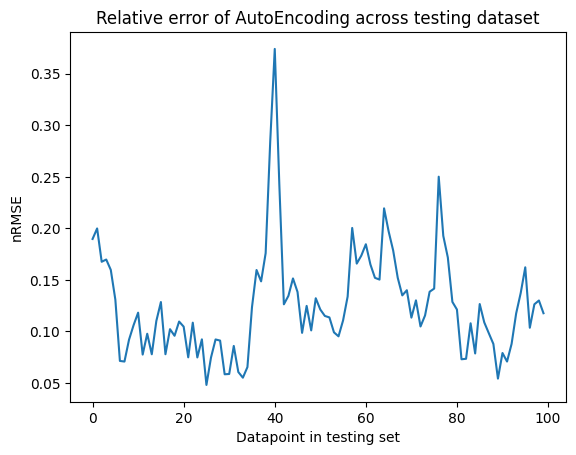

In [68]:
size1 = np.shape(mid_point_decoded_training)
size2 = np.shape(testing_time_serie)
print('mid_point_decoded_training',size1)
print('testing_time_serie',size2)
error = []
for count, i in enumerate(mid_point_decoded_training):
    for j in np.arange(0,size1[1],1):
        err = np.linalg.norm(i[j].flatten()-testing_time_serie[count][j].flatten())/np.linalg.norm(testing_time_serie[count][j].flatten())
        error.append(err)
err = np.mean(error)

print('average nRMSE = ', err)
plt.plot(error)
plt.xlabel('Datapoint in testing set')
plt.ylabel('nRMSE') 
plt.title('Relative error of AutoEncoding across testing dataset')
print('Sigmas: ',sigmas[0] )
print('log_variances_fields: ',log_variances_fields[0])

/tmp/ipykernel_1120230/723162678.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 5)
/tmp/ipykernel_1120230/723162678.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = plt.legend(fontsize = 16)


Testing_T [0.]
Parameters first sample:  [0.4  0.   0.05]
Parameters second sample:  [-0.47  0.    0.05]


<Figure size 2000x1000 with 0 Axes>

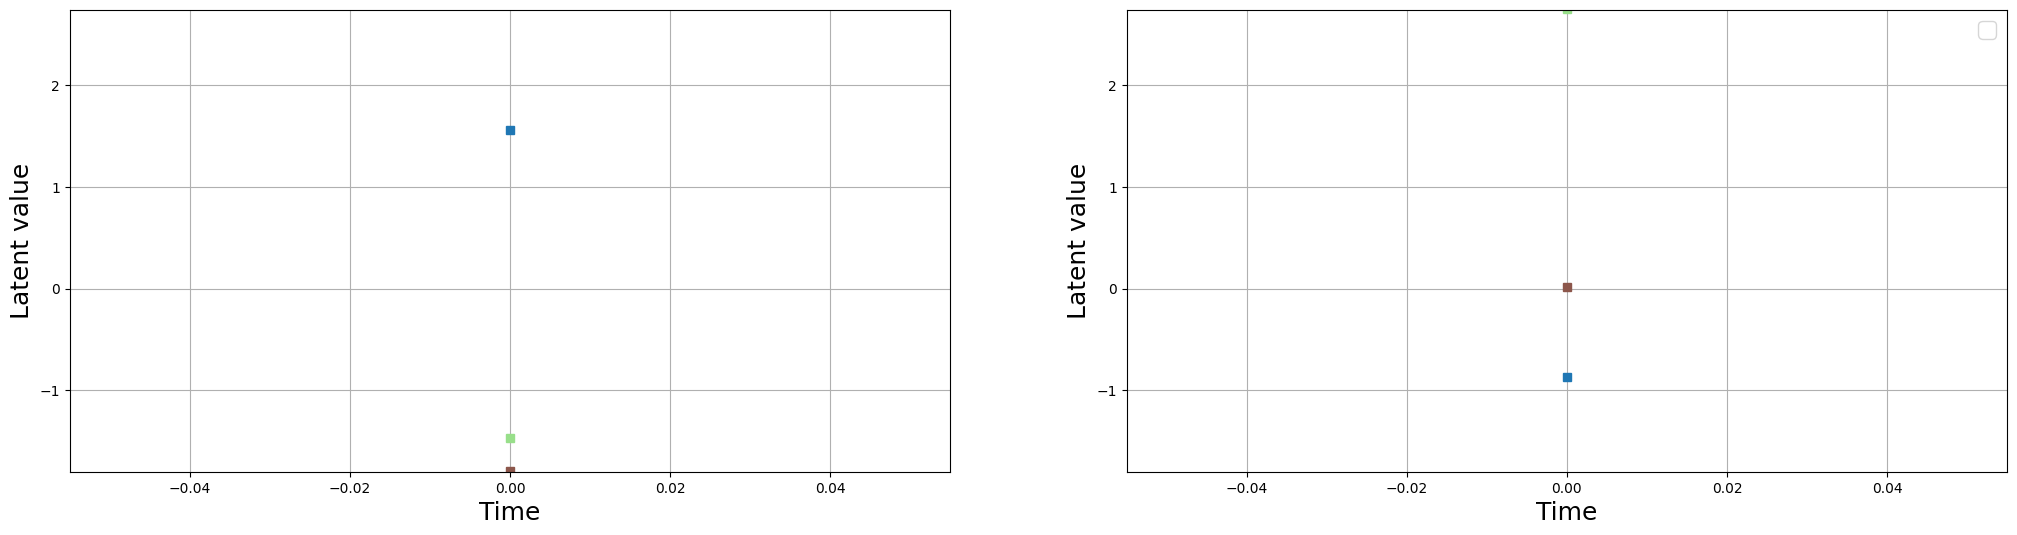

In [69]:
# # LOOK AT LATENT SPACE (FROM ENCODING TRUE SOLUTION ONLY)

plt.figure(figsize=(20,10))
colors = plt.cm.get_cmap('tab20', 5) 
samples = [90, 3]
print('Testing_T', testing_T)
print('Parameters first sample: ', testing_parameters[samples[0]])
print('Parameters second sample: ', testing_parameters[samples[1]])
fig, ax = plt.subplots(1, 2, figsize = (25,6))
for count, i  in enumerate(np.arange(0,3,1)):  
    ax[0].errorbar(testing_T[0:],means[samples[0]][:,i],sigmas[samples[0]][:,i],marker='s',color = colors(count))
    ax[1].errorbar(testing_T[0:],means[samples[1]][:,i],sigmas[samples[1]][:,i],marker='s',color = colors(count))
ma = np.max([np.max(mid_point_encoded_training[samples[0]]),np.max(mid_point_encoded_training[samples[1]])])
mi = np.min([np.min(mid_point_encoded_training[samples[0]]),np.min(mid_point_encoded_training[samples[1]])])
ax[0].set_ylim(mi,ma)
ax[1].set_ylim(mi,ma)

ax[0].grid()
ax[1].grid()
#plt.yscale('log')
ax[0].set_xlabel('Time', fontsize = 18)
ax[1].set_xlabel('Time', fontsize = 18)
ax[0].set_ylabel('Latent value', fontsize = 18)
ax[1].set_ylabel('Latent value', fontsize = 18)
legend = plt.legend(fontsize = 16)
plt.savefig(directory_images+'/latent_varyingt_time_comparison_tot.png',dpi=200,facecolor='w',transparent=True,bbox_inches='tight')

/tmp/ipykernel_1120230/54318815.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 3)


Testing_T [0.]
Parameters first sample:  [0.4  0.   0.05]
Parameters second sample:  [-0.47  0.    0.05]


Text(0, 0.5, 'latent value')

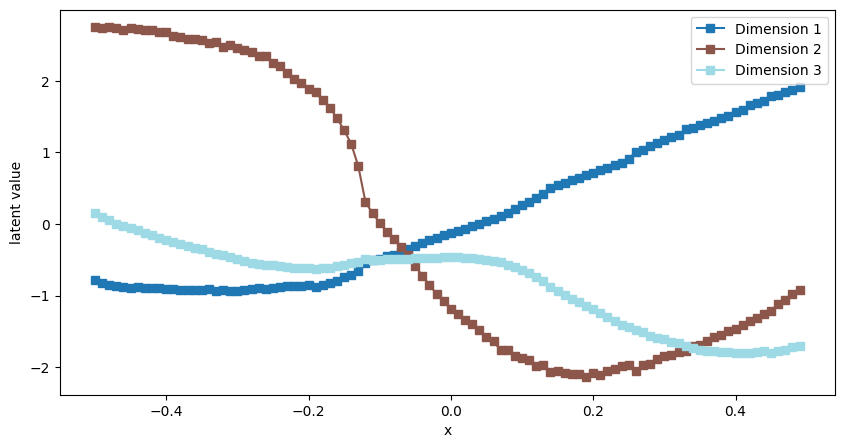

In [70]:
# # LOOK AT LATENT SPACE (FROM ENCODING TRUE SOLUTION ONLY) CHANGE ONLY X
plt.figure(figsize=(10,5))
colors = plt.cm.get_cmap('tab20', 3) 
x = np.arange(-0.5,0.5,0.01)
print('Testing_T', testing_T)
print('Parameters first sample: ', testing_parameters[samples[0]])
print('Parameters second sample: ', testing_parameters[samples[1]])
for i in range(3):  
    plt.plot(x,mid_point_encoded_training[:,:,i],marker='s',color = colors(i), label = 'Dimension '+str(i+1))

legend = plt.legend(fontsize = 10)
plt.xlabel('x')
plt.ylabel('latent value')
#plt.savefig(directory_images+'/latent_varyingt_time_comparison_tot.png',dpi=200,facecolor='w',transparent=True,bbox_inches='tight')

[0.4  0.   0.05]


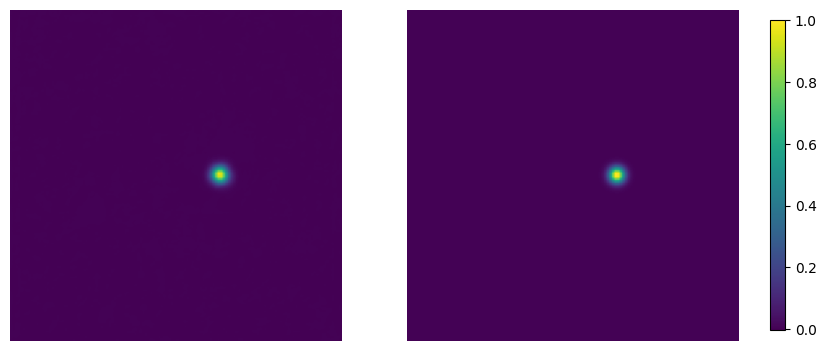

In [73]:
sample = 90
print(testing_parameters[sample])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Get the global min and max across both images
vmin = min(mid_point_decoded_training[sample][0][0].min(), testing_time_serie[sample][0][0].min())
vmax = max(mid_point_decoded_training[sample][0][0].max(), testing_time_serie[sample][0][0].max())

# Show first image
img1 = axes[0].imshow(mid_point_decoded_training[sample][0][0], cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].axis("off")  # Hide axes

# Show second image
img2 = axes[1].imshow(testing_time_serie[sample][0][0], cmap='viridis', vmin=vmin, vmax=vmax)
axes[1].axis("off")  # Hide axes

# Create a truly common colorbar
cbar = fig.colorbar(img1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

plt.show()



# Prediction when Encoding and then Decoding the testing dataset using the **testing** (smaller) dt

In [ ]:
tensor_time_serie = normalize_field_known_values(tc.tensor(testing_time_serie_diff_time, device=device),ma_field,mi_field)
size = tensor_time_serie.size() #should be of size [B,T,C,W,H]
if dim_field[1] == 1:
    tensor_time_serie = tc.reshape(tensor_time_serie, (size[0]*size[1],size[2],size[3]))
elif dim_field[1] == 2:
    tensor_time_serie = tc.reshape(tensor_time_serie, (size[0]*size[1],size[2],size[3],size[4]))

with tc.no_grad():
    mid_point_encoded_inference = conv_encoder(tensor_time_serie)
    mid_point_decoded = conv_decoder(mid_point_encoded_inference)
mid_point_encoded_inference = tc.reshape(mid_point_encoded_inference, (size[0],size[1],latent_dim)).detach().cpu().numpy()
mid_point_decoded = inverse_normalization_field(mid_point_decoded,ma_field,mi_field,dim_field[1])
if dim_field[1] == 1: 
    mid_point_decoded_inference = tc.reshape(mid_point_decoded, (size[0],size[1],size[2],size[3])).detach().cpu().numpy()
elif dim_field[1] == 2:
    mid_point_decoded_inference = tc.reshape(mid_point_decoded, (size[0],size[1],size[2],size[3],size[4])).detach().cpu().numpy() 

print('mid_point_decoded_inference', np.shape(mid_point_decoded_inference))

In [ ]:
size1 = np.shape(mid_point_decoded_inference)
size2 = np.shape(testing_time_serie_diff_time)
print('mid_point_decoded_inference',size1)
print('testing_time_serie_diff_time',np.shape(testing_time_serie_diff_time))
error = []
for count, i in enumerate(mid_point_decoded_inference):
    for j in np.arange(1,size1[1],1):
        err = np.linalg.norm(i[j].flatten()-testing_time_serie_diff_time[count][j].flatten())/np.linalg.norm(testing_time_serie_diff_time[count][j].flatten())
        error.append(err)
err = np.mean(error)
print('average nRMSE = ', err)
plt.plot(error)
plt.xlabel('Datapoint in testing set')
plt.ylabel('nRMSE') 
plt.title('Relative error of AutoEncoding across testing dataset')

# Obtain predictions when advancing in latent space at **training** dt

In [ ]:
dataset_testing = CustomStarDataset(data_generation_test + '/testing_initial_conditions.npy', data_generation_test + '/testing_parameter.npy')
testing = DataLoader(dataset_testing, batch_size = dataset_testing.__len__(), num_workers=0, shuffle=False,drop_last=True)

prediction_array_full_dt_training = []
prediction_array_reduced_dt_training = []
with tc.no_grad():
    for ic, p in testing:
        ic = ic.unsqueeze(1) #should be of size [B,1,C,W,H]!
        ic = ic.unsqueeze(1)
        p = p.unsqueeze(-1) #should be of size [B,N_m]!, where N_m is the number of parameters
        print(p.size())
        print(ic.size())
        ic = ic.to(device)
        p = p.to(device)
        t1 = time.time()
        full, reduced = predict_spatio_temporal_norm_param_in_latent_space(conv_encoder, f, conv_decoder, ic, testing_T, p, normalization, K ,device, dim_field[1], ma_field, mi_field, ma_p, mi_p,dim_field, time_dependence_in_f)
        t2 = time.time()
        prediction_array_full_dt_training.append(full)
        prediction_array_reduced_dt_training.append(reduced)
        print(t2-t1)
prediction_array_full_dt_training = prediction_array_full_dt_training[0]
prediction_array_reduced_dt_training = prediction_array_reduced_dt_training[0]

In [ ]:
size1 = np.shape(prediction_array_full_dt_training)
size2 = np.shape(testing_time_serie)
print('prediction_array_full_dt_training',size1)
print('testing_time_serie',size2)
error_training_dt_latent = []
for count, i in enumerate(prediction_array_full_dt_training):
    for j in np.arange(1,size1[1],1):
        err = np.linalg.norm(i[j].flatten()-testing_time_serie[count][j].flatten())/np.linalg.norm(testing_time_serie[count][j].flatten())
        error_training_dt_latent.append(err)
err = np.mean(error_training_dt_latent)
print('average nRMSE = ', err)
plt.plot(error)
plt.xlabel('Datapoint in testing set')
plt.ylabel('nRMSE') 
plt.title('Relative error of prediction through time across testing dataset')

In [ ]:
# AVERAGE ERROR PER TIME STEP
size1 = np.shape(prediction_array_full_dt_training)
size2 = np.shape(testing_time_serie)
Error1 = []
above_error_treshold = 0
for count, i in enumerate(prediction_array_full_dt_training):
    for j in np.arange(1,size1[1],1):
        error = np.linalg.norm(i[j].flatten()-testing_time_serie[count][j].flatten())/np.linalg.norm(testing_time_serie[count][j].flatten())
        if error > 10.0:
            print(count)
            print(testing_parameters[count])
            above_error_treshold+=1
            Error1.append(error)
            
        else:
            Error1.append(error)
relative_error_per_second1 = []
Error1 = np.array(Error1)
for i in range((len(testing_T)-1)):
    relative_error_per_second1.append(np.sum(Error1[i:][::(len(testing_T)-1)])/len(np.where(Error1[i:][::(len(testing_T)-1)]!=0)[0]))
print('Above error treshold',above_error_treshold )

plt.plot(testing_T[1:], relative_error_per_second1, '*')
plt.xlabel('time')
plt.ylabel('nRMSE') 
plt.title('Average nRMSE per time step')

# Obtain predictions when advancing in latent space at **testing** (smaller) dt

In [ ]:
dataset_testing = CustomStarDataset(data_generation_test + '/testing_initial_conditions.npy', data_generation_test + '/testing_parameter.npy')
testing = DataLoader(dataset_testing, batch_size = dataset_testing.__len__(), num_workers=0, shuffle=False,drop_last=True)
prediction_array_full_dt_inference = []
prediction_array_reduced_dt_inference = []
with tc.no_grad():
    for ic, p in testing:
        ic = ic.unsqueeze(1) #should be of size [B,T,C,W,H]!
        ic = ic.unsqueeze(1)
        p = p.unsqueeze(-1) #should be of size [B,N_m]!, where N_m is the number of parameters
        print(np.shape(ic))
        ic = ic.to(device)
        p = p.to(device)
        full, reduced = predict_spatio_temporal_norm_param_in_latent_space(conv_encoder, f, conv_decoder, ic, inference_T, p, normalization, K ,device, dim_field[1], ma_field, mi_field, ma_p, mi_p, dim_field, time_dependence_in_f)
        prediction_array_full_dt_inference.append(full)
        prediction_array_reduced_dt_inference.append(reduced)
prediction_array_full_dt_inference = prediction_array_full_dt_inference[0]
prediction_array_reduced_dt_inference = prediction_array_reduced_dt_inference[0]

In [ ]:
size1 = np.shape(prediction_array_full_dt_inference)
size2 = np.shape(testing_time_serie_diff_time)
print('prediction_array_full_dt_inference',size1)
print('testing_time_serie_diff_time',size2)
error_testing_dt_latent = []

for count, i in enumerate(prediction_array_full_dt_inference):
    for j in np.arange(1,size1[1]):
        err = np.linalg.norm(i[j].flatten()-testing_time_serie_diff_time[count][j].flatten())/np.linalg.norm(testing_time_serie_diff_time[count][j].flatten())
        error_testing_dt_latent.append(err)
err2 = np.mean(error_testing_dt_latent)
print('rel error' , err2)
plt.plot(error_testing_dt_latent)

In [ ]:
# AVERAGE ERROR PER TIME STEP

size1 = np.shape(prediction_array_full_dt_inference)
size2 = np.shape(testing_time_serie_diff_time)
Error2 = []
above_error_treshold = 0
for count, i in enumerate(prediction_array_full_dt_inference):
    for j in np.arange(1,size1[1],1):
        error = np.linalg.norm(i[j]-testing_time_serie_diff_time[count][j])/(np.linalg.norm(testing_time_serie_diff_time[count][j]))
        if error > 10.0:
            print(count)
            print(testing_parameters[count])
            above_error_treshold+=1
            Error2.append(error)
            
        else:
            Error2.append(error)
relative_error_per_second2 = []
Error2 = np.array(Error2)
for i in range((len(inference_T)-1)):
    relative_error_per_second2.append(np.sum(Error2[i:][::(len(inference_T)-1)])/len(np.where(Error2[i:][::(len(inference_T)-1)]!=0)[0]))

print('Above error treshold',above_error_treshold )

plt.plot(inference_T[1:], relative_error_per_second2, '*')
plt.xlabel('time')
plt.ylabel('nRMSE') 
plt.title('Average nRMSE per time step')

In [ ]:
# plot the two errors over time when using different dt across the prediction
plt.figure(figsize = (10,5))
plt.plot(inference_T[1:],relative_error_per_second2,'o')
plt.xlabel(r'$t$',fontsize = 12)
plt.ylabel(r'$R_r^2(T)$',fontsize = 12)
#plt.yscale('log')
#plt.ylim([0.002,1])
plt.grid()
plt.savefig(directory_images+'error_over_time.png',dpi=200,facecolor='w',transparent=True,bbox_inches='tight')

plt.plot(testing_T[1:],relative_error_per_second1,'o', label = 'dt = 0.05')
plt.plot(inference_T[1:],relative_error_per_second2,'o', label = 'dt = 0.01')
plt.xlabel('time',fontsize = 12)
plt.ylabel('Average nRMSE',fontsize = 12)
plt.legend(fontsize = 12)
#plt.yscale('log')
#plt.ylim([0.002,1])
plt.grid()
#plt.ylim([0.0017,0.013])
#plt.savefig(directory_images+'error_over_time_comparison.png',dpi=200,facecolor='w',transparent=True,bbox_inches='tight')

# Error in the latent space

In [ ]:
size1 = np.shape(prediction_array_reduced_dt_training)
size2 = np.shape(mid_point_encoded_training)
print('prediction_array_reduced_dt_training', size1)
print('mid_point_encoded_training', size2)
Error1_reduced = []
above_error_treshold = 0
for count, i in enumerate(prediction_array_reduced_dt_training):
    for j in np.arange(1,size1[1],1):
        error = np.linalg.norm(i[j].flatten()-mid_point_encoded_training[count][j].flatten())/np.linalg.norm(mid_point_encoded_training[count][j].flatten())
        if error > 10.0:
            print(count)
            print(testing_parameters[count])
            above_error_treshold+=1
            Error1_reduced.append(error)
            
        else:
            Error1_reduced.append(error)
relative_error_per_second1_reduced = []
Error1_reduced = np.array(Error1_reduced)
for i in range((len(testing_T)-1)):
    relative_error_per_second1_reduced.append(np.sum(Error1_reduced[i:][::(len(testing_T)-1)])/len(np.where(Error1_reduced[i:][::(len(testing_T)-1)]!=0)[0]))
size1 = np.shape(prediction_array_reduced_dt_inference)
size2 = np.shape(mid_point_encoded_inference)
print('prediction_array_reduced_dt_inference', size1)
print('mid_point_encoded_inference', size2)
Error2_reduced = []
above_error_treshold = 0
for count, i in enumerate(prediction_array_reduced_dt_inference):
    for j in np.arange(1,size1[1],1):
        error = np.linalg.norm(i[j].flatten()-mid_point_encoded_inference[count][j].flatten())/np.linalg.norm(mid_point_encoded_inference[count][j].flatten())
        if error > 9:
            print(count)
            print(testing_parameters[count])
            above_error_treshold+=1
            Error2_reduced.append(error)
            
        else:
            Error2_reduced.append(error)
relative_error_per_second2_reduced = []
Error2_reduced = np.array(Error2_reduced)
for i in range((len(inference_T)-1)):
    relative_error_per_second2_reduced.append(np.sum(Error2_reduced[i:][::(len(inference_T)-1)])/len(np.where(Error2_reduced[i:][::(len(inference_T)-1)]!=0)[0]))

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(testing_T[1:],relative_error_per_second1_reduced,'o', label = 'dt = 0.05')
plt.plot(inference_T[1:],relative_error_per_second2_reduced,'o', label = 'dt = 0.01')
plt.xlabel(r'$t$',fontsize = 12)
plt.ylabel('Average nRMSE in Reduced space',fontsize = 12)
plt.legend(fontsize = 12)
#plt.yscale('log')
#plt.ylim([0.002,1])
plt.grid()

# Look at the latent space evolution for specific samples

In [ ]:
# # CONFRONT LATENT SPACE (with when solved only in latent training)
plt.figure(figsize=(20,10))
colors = plt.cm.get_cmap('tab20', 60) 
sample = 70
for count, i  in enumerate(np.arange(0,30,1)):  
    plt.plot(testing_T[0:],prediction_array_reduced_dt_training[sample][:,i],'+',markersize = 20,color = colors(count))
    plt.plot(testing_T[0:],mid_point_encoded_training[sample][:,i],'o',color = colors(count))
    plt.plot(inference_T,prediction_array_reduced_dt_inference[sample][:,i], "--",markersize = 20, color = colors(count))
plt.grid()
plt.xticks(testing_T)
#plt.yscale('log')
plt.scatter([], [], marker='o', color = 'k', label='True latent (encoding the true fields)') 
plt.scatter([], [], marker='+', color = 'k', label='Latent predicted on training dt (solving only in latent)') 
plt.scatter([], [], marker=0, color = 'k', label='Latent predicted on smaller dt (solving only in latent)') 
plt.xlabel('Time', fontsize = 18)
plt.ylabel('Latent value', fontsize = 18)
legend = plt.legend(fontsize = 16)
#plt.savefig(directory_images+'/latent_varyingt_time_comparison_tot.png',dpi=200,facecolor='w',transparent=True,bbox_inches='tight')

# Inference time 

In [ ]:
#how much time
#print(np.shape(ic))
dataset_testing = CustomStarDataset(data_generation_test + '/testing_initial_conditions.npy', data_generation_test + '/testing_parameter.npy')
testing = DataLoader(dataset_testing, batch_size = 64, num_workers=0, shuffle=True,drop_last=False)
TIME = []
prediction_array_full_dt_training = []
prediction_array_reduced_dt_training = []
for i in range(1000):
    t = []
    with tc.no_grad():
        for ic, p in testing:
            
            ic = ic.unsqueeze(1) #should be of size [B,T,C,W,H]!
            ic = ic.unsqueeze(1)
            p = p.unsqueeze(-1)
            ic = ic.to(device)
            p = p.to(device)
            start = tc.cuda.Event(enable_timing=True)
            end = tc.cuda.Event(enable_timing=True)
            start.record()
            full = predict_spatio_temporal_norm_param_in_latent_space_for_time_inference(conv_encoder, f, conv_decoder, ic, testing_T, p, normalization, K ,device, dim_field[1], ma_field, mi_field, ma_p, mi_p,dim_field, time_dependence_in_f)
            end.record()
            tc.cuda.synchronize()
            if i > 10:
                t.append(start.elapsed_time(end))
    TIME.append(np.sum(t))
print('Average time', np.average(TIME))
print('STD time' , np.std(TIME))